## Scaling non-bipartite graph demo (lastfm)

### Overview

This notebooks demonstates the scaling capabilities of syngen non-bipartite generators.

#### Imports

In [1]:
# preprocessing
from syngen.preprocessing.base_preprocessing import BasePreprocessing

# Generator
from syngen.synthesizer import StaticGraphSynthesizer, RandomSynthesizer
from syngen.generator.graph import RMATGenerator

# evaluation
from syngen.analyzer.graph.frechet import get_frechet_score_normalized

# utils
import math
import cudf
import numpy as np
import pandas as pd
from pprint import pprint
from matplotlib import pyplot as plt
from syngen.utils.types import MetaData

#### Prepare synthesizers

The synthesizer is prepared simply using the graph generator, which will generate the graph structure.

In this case no features will be generated.

In [2]:
static_graph_generator = RMATGenerator()
preprocessing = BasePreprocessing()

In [3]:
synthesizer = StaticGraphSynthesizer(
    graph_generator=static_graph_generator,
    graph_info=preprocessing.graph_info,
    is_directed=False
)
random_synthesizer = RandomSynthesizer(is_directed=False, bipartite=False)

#### Load data

The original dataset is loaded.

**Note**: to obtain the datasets run the `/scripts/get_datasets.sh` script as described in the `README.md`

In [4]:
%%time
edge_list = np.loadtxt('/workspace/data/lasftm_asia/lastfm_asia_edges.csv', delimiter=',', skiprows=1, dtype=np.int32)
edge_data = pd.DataFrame(edge_list, columns=['src', 'dst'])
num_edges, num_nodes = 27806, 7624

CPU times: user 81.9 ms, sys: 8.82 ms, total: 90.7 ms
Wall time: 122 ms


#### Fit synthesizer

In [5]:
synthesizer.fit(edge_data = edge_data)

In [6]:
synthesizer.graph_generator.get_fit_results()

(0.5241325378417971,
 0.1747108459472657,
 0.1747108459472657,
 0.12644577026367143)

#### Generate and compare graphs

To check the generator scaling capabilities we compare the results of randomly and properly generated graphs with the original graph. There is no trivial way to scale the original graph, so we use Normalized Frechet Score. It takes all of three graphs, normalizes their degree distribution curves using moving average, smoothes using log transformation,, computes [Frechet Distance](https://en.wikipedia.org/wiki/Fr%C3%A9chet_inception_distance) for original and generated graphs, and compares these distances.


In [7]:
a,b,c,d = synthesizer.graph_generator.get_fit_results()


tmp_alls = [
     ((a-x, b+x*1/16, c+x*9/16, d+x*6/16), x) for x in [0.1] 
]

alls = [((a, b, c, d), 0.0)] + tmp_alls + [((0.25, 0.25, 0.25, 0.25), 1.0)]

pprint(alls)

scalings = {}
plots = []

e_list_original = edge_data.to_numpy()

for scaling in [-4, -3, -2, -1, 0, 1, 2, 3]:
    results = []
    n_num_nodes = int(num_nodes * 2**scaling)
    n_num_edges = int(num_edges * 2**scaling * 2**scaling)
    
    print("SCALE", scaling)
    print("BASE X", math.ceil(math.log2(num_nodes)))
    print("Current X", math.ceil(math.log2(n_num_nodes)))
    print("BASE DENSITY", num_edges/num_nodes)
    print("CURRENT DENSITY", n_num_edges/n_num_nodes)

    if n_num_nodes % 2 == 1:
        n_num_nodes +=1
    
    if n_num_edges % 2 == 1:
        n_num_edges +=1
    
    generated_random_data = random_synthesizer.generate(num_nodes=n_num_nodes, num_edges= n_num_edges, graph_noise=0.5)
    random_to_normalize_list = generated_random_data[MetaData.EDGE_DATA].to_numpy()
    
    for theta, x in alls:
        synthesizer.graph_generator.set_fit_results(theta)
        generated_data = synthesizer.generate(n_num_nodes, n_num_edges, graph_noise=0.5)
        e_list = generated_data[MetaData.EDGE_DATA].to_numpy()
        
        dd = get_frechet_score_normalized(e_list_original, e_list, random_to_normalize_list, cdf_points=1000)
        a_n, b_n, c_n, d_n = theta
        theta_new = np.around(a_n, 2), np.around(b_n, 2), np.around(c_n, 2), np.around(d_n, 2)
        results.append((theta_new, x, np.around(dd, 2)))
        plots.append((theta_new, x, e_list))
    scalings[scaling] = results

[((0.5241325378417971,
   0.1747108459472657,
   0.1747108459472657,
   0.12644577026367143),
  0.0),
 ((0.42413253784179716,
   0.18096084594726572,
   0.2309608459472657,
   0.16394577026367144),
  0.1),
 ((0.25, 0.25, 0.25, 0.25), 1.0)]
SCALE -4
BASE X 13
Current X 9
BASE DENSITY 3.6471668415529908
CURRENT DENSITY 0.226890756302521
SCALE -3
BASE X 13
Current X 10
BASE DENSITY 3.6471668415529908
CURRENT DENSITY 0.45540398740818466
SCALE -2
BASE X 13
Current X 11
BASE DENSITY 3.6471668415529908
CURRENT DENSITY 0.9113326337880377
SCALE -1
BASE X 13
Current X 12
BASE DENSITY 3.6471668415529908
CURRENT DENSITY 1.8234522560335782
SCALE 0
BASE X 13
Current X 13
BASE DENSITY 3.6471668415529908
CURRENT DENSITY 3.6471668415529908
SCALE 1
BASE X 13
Current X 14
BASE DENSITY 3.6471668415529908
CURRENT DENSITY 7.2943336831059815
SCALE 2
BASE X 13
Current X 15
BASE DENSITY 3.6471668415529908
CURRENT DENSITY 14.588667366211963
SCALE 3
BASE X 13
Current X 16
BASE DENSITY 3.6471668415529908
CURRENT 

In [8]:
pprint(scalings)

{-4: [((0.52, 0.17, 0.17, 0.13), 0.0, 0),
      ((0.42, 0.18, 0.23, 0.16), 0.1, 0),
      ((0.25, 0.25, 0.25, 0.25), 1.0, 0)],
 -3: [((0.52, 0.17, 0.17, 0.13), 0.0, 0.1),
      ((0.42, 0.18, 0.23, 0.16), 0.1, 0.15),
      ((0.25, 0.25, 0.25, 0.25), 1.0, 0.21)],
 -2: [((0.52, 0.17, 0.17, 0.13), 0.0, 0.08),
      ((0.42, 0.18, 0.23, 0.16), 0.1, 0.17),
      ((0.25, 0.25, 0.25, 0.25), 1.0, 0)],
 -1: [((0.52, 0.17, 0.17, 0.13), 0.0, 0.75),
      ((0.42, 0.18, 0.23, 0.16), 0.1, 0.36),
      ((0.25, 0.25, 0.25, 0.25), 1.0, 0.48)],
 0: [((0.52, 0.17, 0.17, 0.13), 0.0, 0.46),
     ((0.42, 0.18, 0.23, 0.16), 0.1, 0.88),
     ((0.25, 0.25, 0.25, 0.25), 1.0, 0.97)],
 1: [((0.52, 0.17, 0.17, 0.13), 0.0, 0.25),
     ((0.42, 0.18, 0.23, 0.16), 0.1, 0.74),
     ((0.25, 0.25, 0.25, 0.25), 1.0, 0)],
 2: [((0.52, 0.17, 0.17, 0.13), 0.0, 0),
     ((0.42, 0.18, 0.23, 0.16), 0.1, 0),
     ((0.25, 0.25, 0.25, 0.25), 1.0, 0.01)],
 3: [((0.52, 0.17, 0.17, 0.13), 0.0, 0),
     ((0.42, 0.18, 0.23, 0.16), 0.1, 0

#### Show results

The next couple cells computers the frechet distance over the generated synthetic graph sand the original graph using the fitted parameters as well as the erdos renyi graph.

In [9]:
p1, p2, p3 = [[], [], 'NA'], [[], [], 'NA'], [[], [], 'NA']
for x, zz in scalings.items():
    p1[0].append(x)
    p2[0].append(x)
    p3[0].append(x)
    for a, b, c in zz:
        if b < 0.1:
            p1[1].append(c)
            p1[2] = f'{a} | {b}'
        elif b < 0.2:
            p2[1].append(c)
            p2[2] = f'{a} | {b}'
        elif b < 2.0:
            p3[1].append(c)
            p3[2] = f'{a} | {b}'
    

In [10]:
plt.figure(figsize=(16, 8), dpi=800)

for xs, ys, text in [p1, p2, p3]:
    plt.plot(xs, ys, '--x', label=text)

plt.legend()
plt.title('Frechet distance for different graph scale and degree distribution')
plt.xlabel("Graph scale (0 means same size as original)")
plt.ylabel("Normalized frechet distance (higher is better)")

plt.show()

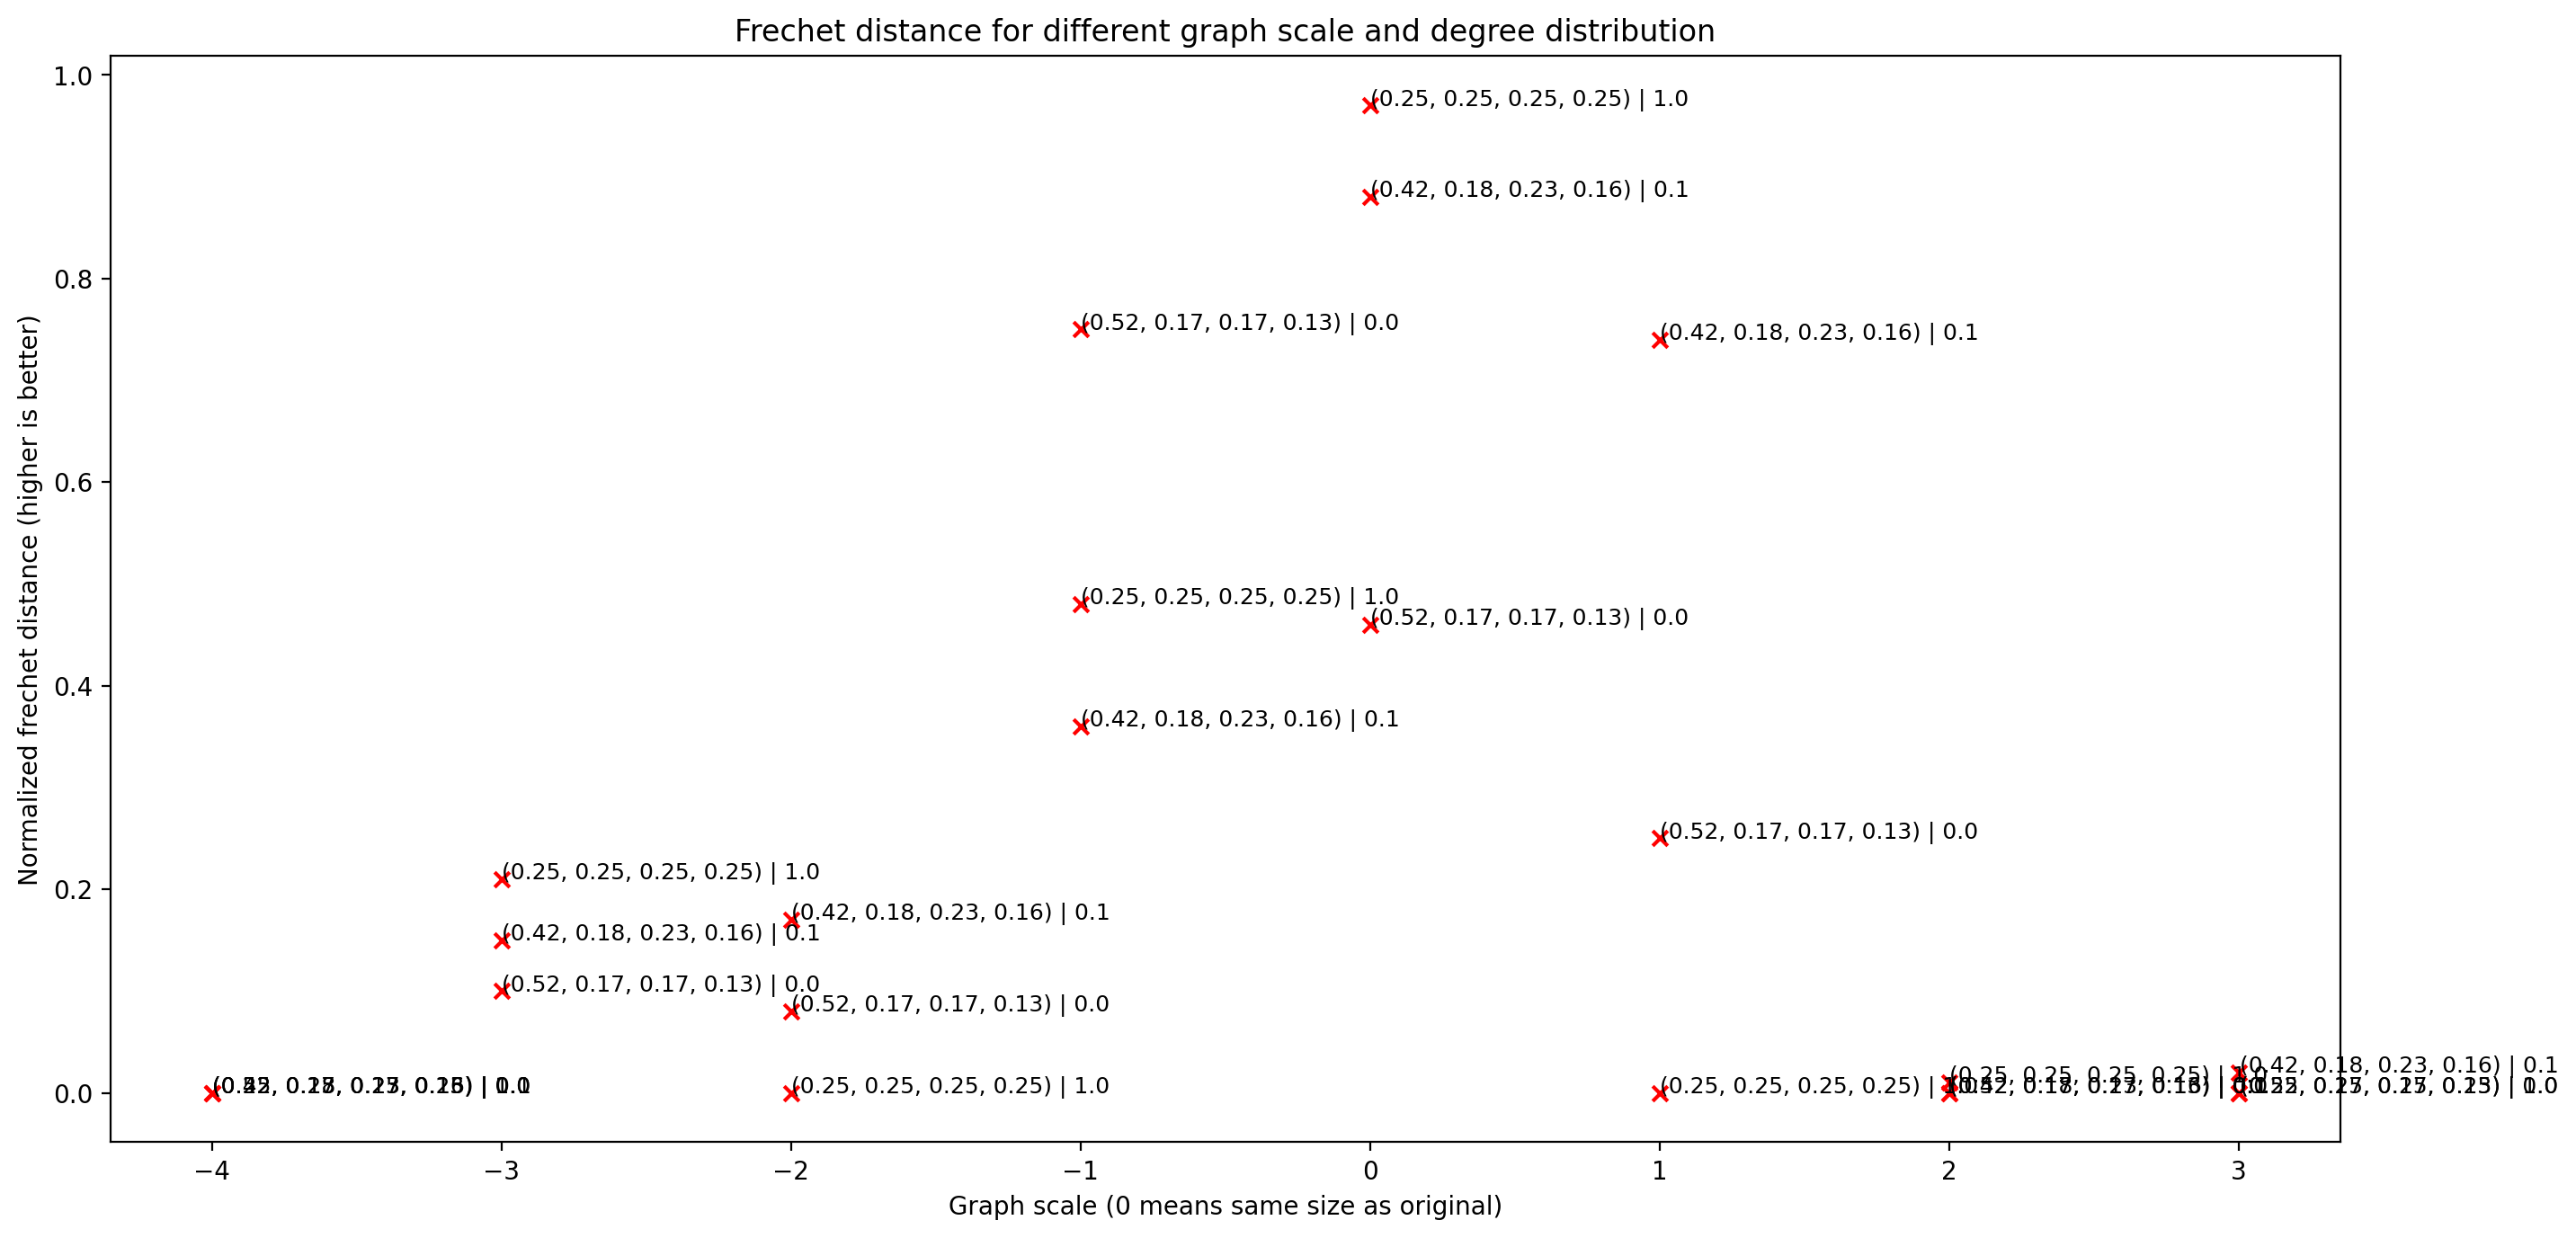

In [11]:
plt.figure(figsize=(16, 8), dpi=200)

for x, results in scalings.items():
    xs = []
    ys = []
    for theta, diff, dd in results:
        x, y = int(x), dd
        plt.scatter(x, y, marker='x', color='red')
        text = f'{theta} | {diff}'
        plt.text(x+0.001, y, text, fontsize=9)

plt.title('Frechet distance for different graph scale and degree distribution')
plt.xlabel("Graph scale (0 means same size as original)")
plt.ylabel("Normalized frechet distance (higher is better)")
plt.show()